Notebook for training a 3D U-Net for vestibular schwannoma segmentation.

In [ ]:
# This cell is for Colab runs

!pip install tensorflow==2.10.1  # same version of tf used in local testing, Colab default (2.13) gives import errors with segmentation models library

!pip install segmentation_models_3D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
import pandas as pd
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [3]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_DEPTH = 64
IMG_CHANNELS = 1
SEED = 42
random.seed(SEED)

Connect to Drive if running on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Load the data.

In [4]:
#Colab data paths
# mris_path = "/content/drive/MyDrive/bsc_thesis_data_t1_numpy/mris_dataset.npy"
# masks_path = "/content/drive/MyDrive/bsc_thesis_data_t1_numpy/masks_dataset.npy"

# Paths on local machine
mris_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\mris_dataset_64.npy"
masks_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\masks_dataset_64.npy"

mris = np.load(mris_path)
masks = np.load(masks_path)



In [5]:
mris.shape

(242, 64, 64, 64)

In [6]:
masks.shape

(242, 64, 64, 64)

Normalise the data.

In [7]:
def normalize_3d_image(img):
    return (img - img.min()) / (img.max() - img.min())


# def standardize_3d_image(img):
#     """
#     Standardize a 3D image using Z-score normalization.

#     Parameters:
#     - img: 3D numpy array representing the MRI image.

#     Returns:
#     - standardized_img: 3D numpy array representing the standardized MRI image.
#     """
#     mean = np.mean(img)
#     std = np.std(img)
#     standardized_img = (img - mean) / std
#     return standardized_img

Normalise the data and print out the min and max pixel intensities before and after.

In [8]:
print(np.min(mris))
print(np.max(mris))

-195.05598
4172.222


In [9]:
for i in range(mris.shape[0]):
    mris[i] = normalize_3d_image(mris[i])

In [10]:
print(np.min(mris))
print(np.max(mris))

0.0
1.0


In [11]:
# Create an array of indices corresponding to the original dataset
indices = np.arange(len(mris))

X_train, X_test, Y_train, Y_test, train_indices, test_indices = train_test_split(
    mris, masks, indices, test_size=0.20, shuffle=True, random_state=SEED
)

Function for building the model.

In [12]:
def build():

  model = sm.Unet(
      "resnet34",
      input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, IMG_CHANNELS),
      encoder_weights=None,
      activation="sigmoid",
  )


  dice_loss = sm.losses.DiceLoss()
  bce_loss = sm.losses.BinaryCELoss()
  total_loss = dice_loss + bce_loss


  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
  )
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
      loss=total_loss,
      metrics=[sm.metrics.IOUScore()],
  )
  return model

Initialise the k-fold cross validation and lists to store evaluation metrics.

In [13]:
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

#indices = np.arange(len(mris)) # Array for patient indices for retracing patients after cross-validation shuffle. 
train_iou_list = []
#val_iou_list = []
dataframes = []

In [14]:
def build_dfs(test_ids, dice_scores):
    data = {
        "Patient Indices": test_ids,
        "Dice": dice_scores
    }
    # Create DataFrame
    df = pd.DataFrame(data)
    # Calculate the average and standard deviation of dice_scores
    avg_dice = np.mean(dice_scores)
    std_dice = np.std(dice_scores)
    
    # add a new row with average and standard deviation
    df = pd.concat([df, pd.DataFrame({"Patient Indices": ["Avg."], "Dice": [f"{avg_dice:.2f}"]})], ignore_index=True)
    df = pd.concat([df, pd.DataFrame({"Patient Indices": ["Std."], "Dice": [f"{std_dice:.2f}"]})], ignore_index=True)

    
    return df

Create a function to evaluate the segmentation performance.

In [15]:
def getScore(predictions, test_mask):
    intersection = np.logical_and(test_mask, predictions)
    dice_score = (np.sum(intersection) * 2) / (np.sum(predictions) + np.sum(test_mask))

    return dice_score

Train the model inside the cross-validation loop.

In [16]:
fold = 1
for train_index, val_index in kf.split(X_train, Y_train):
  # Split data
  X_train_fold, X_val = X_train[train_index], X_train[val_index]
  Y_train_fold, Y_val = Y_train[train_index], Y_train[val_index]
  train_ids, val_ids = train_indices[train_index], train_indices[val_index]

  print(
      f"Training data\nDimensions: {X_train_fold.shape}\nMax-value: {np.max(X_train_fold)}\nMin-value: {np.min(X_train_fold)}"
  )
  print(
    f"Test data\nDimensions: {X_val.shape}\nMax-value: {np.max(X_val)}\nMin-value: {np.min(X_val)}"
  )
  model = build()
  history = model.fit(
    X_train_fold, Y_train_fold, epochs=50, batch_size=8
  )

  train_iou_list.append(history.history["iou_score"])
  #val_iou_list.append(history.history["val_iou_score"])

  # Loop through each item, predict, and calculate scores

  dice_scores = [] # list for containing an individual test folds dice scores

  for i in range(X_val.shape[0]):
      single_item = np.expand_dims(X_val[i], axis=0)
      pred = model.predict(single_item)
      pred_t = (pred > 0.5).squeeze()  #  remove any singleton dimensions
      Y_val_single = Y_val[i]
      dice_score = getScore(pred_t, Y_val_single)

      dice_scores.append(dice_score)
  print(np.mean(dice_scores))
  dataframes.append(build_dfs(val_ids, dice_scores))
  model.save(r"C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_"+ str(fold))
  fold +=1


Training data
Dimensions: (154, 64, 64, 64)
Max-value: 1.0
Min-value: 0.0
Test data
Dimensions: (39, 64, 64, 64)
Max-value: 1.0
Min-value: 0.0
Epoch 1/50
20/20 [==============================] - 43s 1s/step - loss: 1.3429 - iou_score: 6.3090e-04
Epoch 2/50
20/20 [==============================] - 18s 886ms/step - loss: 1.0444 - iou_score: 0.0016
Epoch 3/50
20/20 [==============================] - 20s 1s/step - loss: 1.0124 - iou_score: 0.0040
Epoch 4/50
20/20 [==============================] - 20s 978ms/step - loss: 0.9676 - iou_score: 0.0234
Epoch 5/50
20/20 [==============================] - 21s 1s/step - loss: 0.8195 - iou_score: 0.1166
Epoch 6/50
20/20 [==============================] - 21s 1s/step - loss: 0.4665 - iou_score: 0.3755
Epoch 7/50
20/20 [==============================] - 20s 970ms/step - loss: 0.3139 - iou_score: 0.5280
Epoch 8/50
20/20 [==============================] - 20s 1s/step - loss: 0.2649 - iou_score: 0.5897
Epoch 9/50
20/20 [==============================] - 

INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_1\assets


INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_1\assets


Training data
Dimensions: (154, 64, 64, 64)
Max-value: 1.0
Min-value: 0.0
Test data
Dimensions: (39, 64, 64, 64)
Max-value: 1.0
Min-value: 0.0
Epoch 1/50
20/20 [==============================] - 28s 1s/step - loss: 1.3618 - iou_score: 5.1046e-04
Epoch 2/50
20/20 [==============================] - 20s 1s/step - loss: 1.0544 - iou_score: 5.2252e-04
Epoch 3/50
20/20 [==============================] - 20s 1s/step - loss: 1.0178 - iou_score: 9.1955e-04
Epoch 4/50
20/20 [==============================] - 20s 1000ms/step - loss: 1.0102 - iou_score: 0.0013
Epoch 5/50
20/20 [==============================] - 20s 1000ms/step - loss: 0.9907 - iou_score: 0.0107
Epoch 6/50
20/20 [==============================] - 19s 963ms/step - loss: 0.9373 - iou_score: 0.0378
Epoch 7/50
20/20 [==============================] - 20s 1s/step - loss: 0.7425 - iou_score: 0.1632
Epoch 8/50
20/20 [==============================] - 20s 1s/step - loss: 0.4075 - iou_score: 0.4391
Epoch 9/50
20/20 [========================

INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_2\assets


INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_2\assets


Training data
Dimensions: (154, 64, 64, 64)
Max-value: 1.0
Min-value: 0.0
Test data
Dimensions: (39, 64, 64, 64)
Max-value: 1.0
Min-value: 0.0
Epoch 1/50
20/20 [==============================] - 25s 1s/step - loss: 1.2730 - iou_score: 5.9822e-04
Epoch 2/50
20/20 [==============================] - 19s 967ms/step - loss: 1.0308 - iou_score: 0.0010
Epoch 3/50
20/20 [==============================] - 20s 1s/step - loss: 1.0066 - iou_score: 0.0039
Epoch 4/50
20/20 [==============================] - 20s 971ms/step - loss: 0.9650 - iou_score: 0.0237
Epoch 5/50
20/20 [==============================] - 20s 1s/step - loss: 0.8279 - iou_score: 0.1048
Epoch 6/50
20/20 [==============================] - 20s 1s/step - loss: 0.5889 - iou_score: 0.2630
Epoch 7/50
20/20 [==============================] - 20s 1s/step - loss: 0.4135 - iou_score: 0.4187
Epoch 8/50
20/20 [==============================] - 20s 1s/step - loss: 0.3325 - iou_score: 0.5070
Epoch 9/50
20/20 [==============================] - 22s

INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_3\assets


INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_3\assets


Training data
Dimensions: (155, 64, 64, 64)
Max-value: 1.0
Min-value: 0.0
Test data
Dimensions: (38, 64, 64, 64)
Max-value: 1.0
Min-value: 0.0
Epoch 1/50
20/20 [==============================] - 29s 1s/step - loss: 1.1983 - iou_score: 8.3824e-04
Epoch 2/50
20/20 [==============================] - 21s 1s/step - loss: 1.0010 - iou_score: 0.0104
Epoch 3/50
20/20 [==============================] - 20s 977ms/step - loss: 0.8967 - iou_score: 0.0631
Epoch 4/50
20/20 [==============================] - 20s 977ms/step - loss: 0.5555 - iou_score: 0.2996
Epoch 5/50
20/20 [==============================] - 20s 1s/step - loss: 0.3296 - iou_score: 0.5165
Epoch 6/50
20/20 [==============================] - 20s 979ms/step - loss: 0.2717 - iou_score: 0.5794
Epoch 7/50
20/20 [==============================] - 20s 982ms/step - loss: 0.2271 - iou_score: 0.6359
Epoch 8/50
20/20 [==============================] - 21s 1s/step - loss: 0.2030 - iou_score: 0.6626
Epoch 9/50
20/20 [==============================]

INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_4\assets


INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_4\assets


Training data
Dimensions: (155, 64, 64, 64)
Max-value: 1.0
Min-value: 0.0
Test data
Dimensions: (38, 64, 64, 64)
Max-value: 1.0
Min-value: 0.0
Epoch 1/50
20/20 [==============================] - 25s 1s/step - loss: 1.1272 - iou_score: 7.6862e-04
Epoch 2/50
20/20 [==============================] - 20s 975ms/step - loss: 0.9943 - iou_score: 0.0103
Epoch 3/50
20/20 [==============================] - 20s 1s/step - loss: 0.9242 - iou_score: 0.0418
Epoch 4/50
20/20 [==============================] - 20s 1s/step - loss: 0.7365 - iou_score: 0.1574
Epoch 5/50
20/20 [==============================] - 20s 1s/step - loss: 0.5748 - iou_score: 0.2732
Epoch 6/50
20/20 [==============================] - 20s 979ms/step - loss: 0.5392 - iou_score: 0.3008
Epoch 7/50
20/20 [==============================] - 20s 980ms/step - loss: 0.5053 - iou_score: 0.3315
Epoch 8/50
20/20 [==============================] - 20s 979ms/step - loss: 0.4858 - iou_score: 0.3472
Epoch 9/50
20/20 [==============================]

INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_5\assets


INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_5\assets


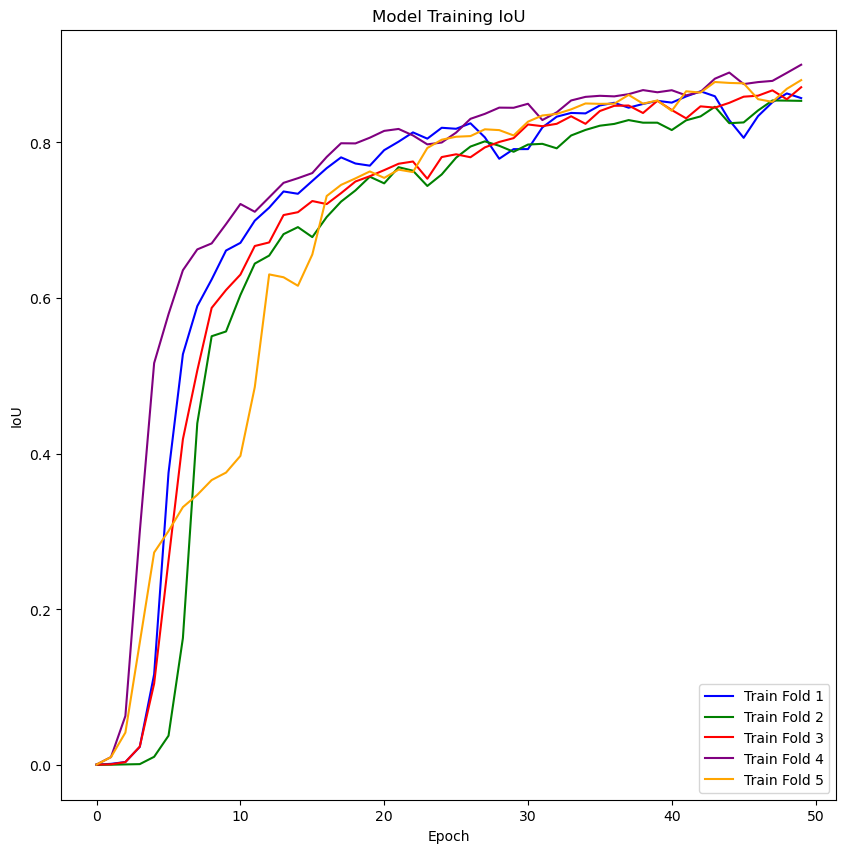

In [33]:
plt.figure(figsize=(10, 10))
colors = ["blue", "green", "red", "purple", "orange"]  # Define colors for the curves
for i, color in enumerate(colors):
    plt.plot(train_iou_list[i], color=color, linestyle="-")

plt.title("Model Training IoU")
plt.ylabel("IoU")
plt.xlabel("Epoch")
plt.legend(
    [
        "Train Fold 1",
        "Train Fold 2",
        "Train Fold 3",
        "Train Fold 4",
        "Train Fold 5",
    ],
    loc="lower right",
)

plt.show()

Write the dataframes to an excel. 

In [17]:
with pd.ExcelWriter(
    r"C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\5_fold_CV_dfs.xlsx"
) as writer:
    for i, df in enumerate(dataframes):
        df.to_excel(writer, sheet_name=f"Fold {i+1}")

Average of 5-fold cross-validation scores. 

In [26]:
dsc_sum = 0
for i, dataframe in enumerate(dataframes):
    dsc_sum += float(dataframe["Dice"].iloc[-2])

print((dsc_sum/len(dataframes)))

0.786


Load the average model and train with the whole dataset. 

In [44]:
avg_model = tf.keras.models.load_model(
    r"C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_1",
    custom_objects={"iou_score": sm.metrics.iou_score, "dice_loss_plus_binary_crossentropy":sm.losses.DiceLoss() + sm.losses.BinaryCELoss()},
)

In [45]:
dice_loss = sm.losses.DiceLoss()
bce_loss = sm.losses.BinaryCELoss()
total_loss = dice_loss + bce_loss

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
  )
avg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=total_loss,
    metrics=[sm.metrics.IOUScore()],
)

Set callback for the training. 

In [46]:
cb = tf.keras.callbacks.EarlyStopping(
      monitor="val_iou_score", mode="max", patience=5, restore_best_weights=True
  )

In [47]:
avg_model_history = avg_model.fit(X_train, Y_train, epochs=50, batch_size=2, validation_split=0.20, callbacks=[cb])

Epoch 1/50
77/77 [==============================] - 34s 375ms/step - loss: 0.1640 - iou_score: 0.7285 - val_loss: 0.1996 - val_iou_score: 0.6804
Epoch 2/50
77/77 [==============================] - 27s 349ms/step - loss: 0.1553 - iou_score: 0.7425 - val_loss: 0.5734 - val_iou_score: 0.2844
Epoch 3/50
77/77 [==============================] - 27s 349ms/step - loss: 0.1216 - iou_score: 0.7875 - val_loss: 0.3612 - val_iou_score: 0.5162
Epoch 4/50
77/77 [==============================] - 27s 352ms/step - loss: 0.1262 - iou_score: 0.7819 - val_loss: 0.1755 - val_iou_score: 0.7277
Epoch 5/50
77/77 [==============================] - 27s 349ms/step - loss: 0.1080 - iou_score: 0.8083 - val_loss: 0.2170 - val_iou_score: 0.6747
Epoch 6/50
77/77 [==============================] - 27s 350ms/step - loss: 0.1143 - iou_score: 0.7984 - val_loss: 0.2007 - val_iou_score: 0.7004
Epoch 7/50
77/77 [==============================] - 27s 350ms/step - loss: 0.1022 - iou_score: 0.8176 - val_loss: 0.2259 - val_iou

Evaluate the average model on the test set.

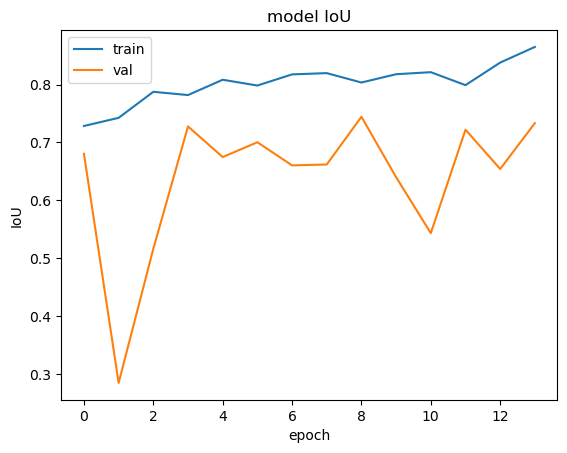

In [51]:
plt.plot(avg_model_history.history["iou_score"])
plt.plot(avg_model_history.history["val_iou_score"])
plt.title("model IoU")
plt.ylabel("IoU")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [48]:
avg_model_dice_scores = [] # list for containing an individual test folds dice scores

for i in range(X_test.shape[0]):
    single_item = np.expand_dims(X_test[i], axis=0)
    pred = model.predict(single_item)
    pred_t = (pred > 0.5).squeeze()  #  remove any singleton dimensions
    Y_test_single = Y_test[i]
    dice_score = getScore(pred_t, Y_test_single)

    avg_model_dice_scores.append(dice_score)
print(np.mean(avg_model_dice_scores))

1/1 [==============================] - 0s 34ms/step
0.7688419027451389


In [49]:
avg_model_df = build_dfs(test_indices, avg_model_dice_scores)

In [50]:
avg_model_df

,Patient Indices,Dice
0,24,0.463158
1,6,0.853147
2,152,0.804878
3,209,0.918519
4,237,0.880952
5,199,0.733333
6,190,0.91129
7,150,0.888421
8,9,0.867327
9,113,0.862069


Create a function to plot patientwise dice scores for the avg. model dataframe.  

In [58]:
def plotDice(dataframe):

    plt.figure(figsize=(10, 20))  # Increased height
    spacing = 1.5  # Adjust this to increase/decrease spacing
    y_positions = np.arange(len(dataframe)-2) * spacing
    plt.barh(y_positions, dataframe["Dice"].iloc[:-2], color="blue", edgecolor="black") # leave out the avg. and std. lines of the df
    plt.ylabel("Index")
    plt.xlabel("Dice Score")
    plt.title("Dice Scores per Index")
    plt.yticks(y_positions, dataframe["Patient Indices"].iloc[:-2])
    
    plt.xlim(0, 1)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


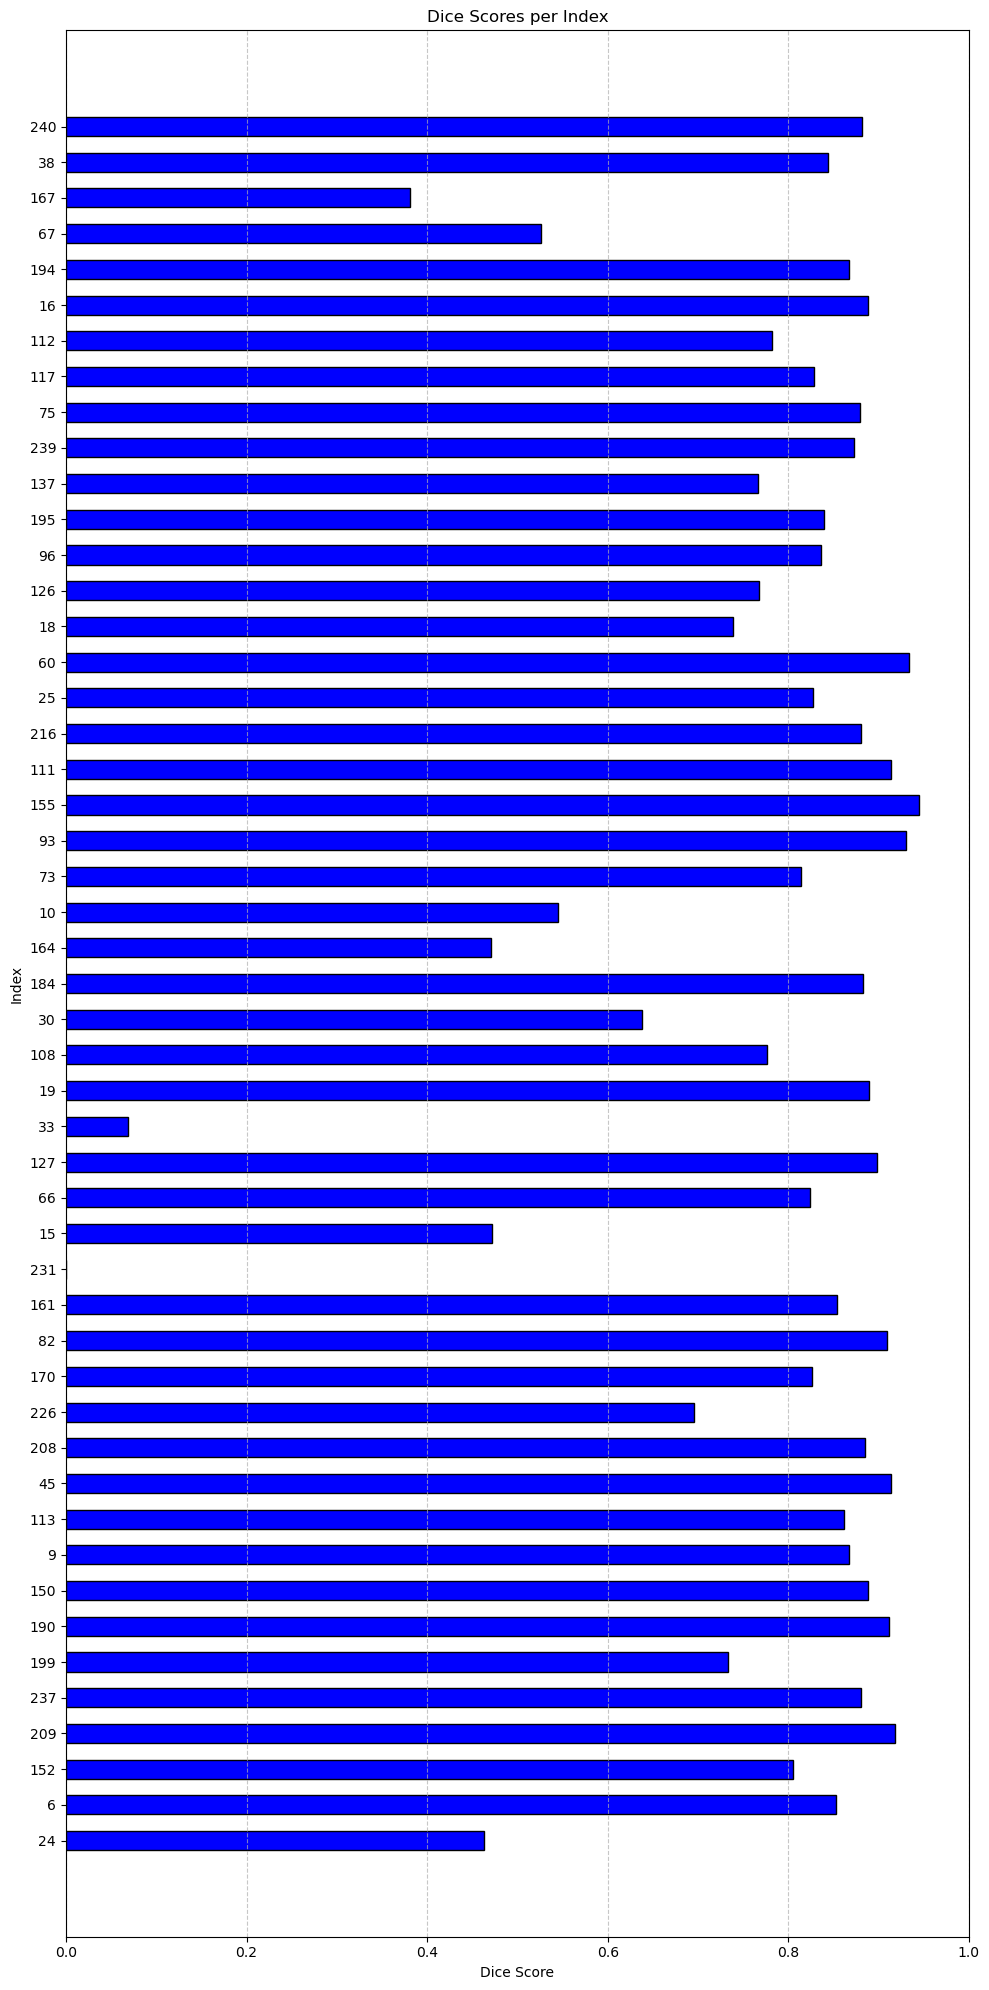

In [59]:
plotDice(avg_model_df)

In [61]:
def plot_test_image_with_contours(index, X_test, Y_test):
    """
    Plots multiple slices of a 3D test image with annotated and predicted contours in the same figure.

    Parameters:
    - index: Index of the test image to plot.
    - X_test: Array of test images.
    - Y_test: Array of annotated masks/lines.
    """

    # Extract the specified test image and its corresponding masks
    img = X_test[index]
    annotated_mask = Y_test[index]

    # Predict the mask
    predicted_mask = avg_model.predict(np.expand_dims(X_test[index, ...], axis=0))
    predicted_mask_t = predicted_mask > 0.5
    slice_indices = [
        i for i in range(img.shape[2]) if np.sum(annotated_mask[:, :, i]) > 0
    ] # Get the slices where annotation

    num_slices = len(slice_indices)
    plt.figure(figsize=(5, 5 * num_slices))

    for i, idx in enumerate(slice_indices):
        plt.subplot(num_slices, 1, i + 1)  # Create a subplot for each slice

        # Display the test image slice
        plt.imshow(img[:, :, idx], cmap="gray")

        # Display the annotated contour (in green color) for the slice
        plt.contour(annotated_mask[:, :, idx], colors="g", linewidths=0.5)

        # Display the predicted contour (in red color) for the slice
        plt.contour(
            predicted_mask_t[0, :, :, idx, 0], colors="r", linewidths=0.5
        )

        plt.title(f"Slice {idx} with Annotated (Green) and Predicted (Red) Contours")
        plt.axis("off")

    plt.tight_layout()
    plt.show()




Plot example from the last validation fold. 

1/1 [==============================] - 0s 38ms/step


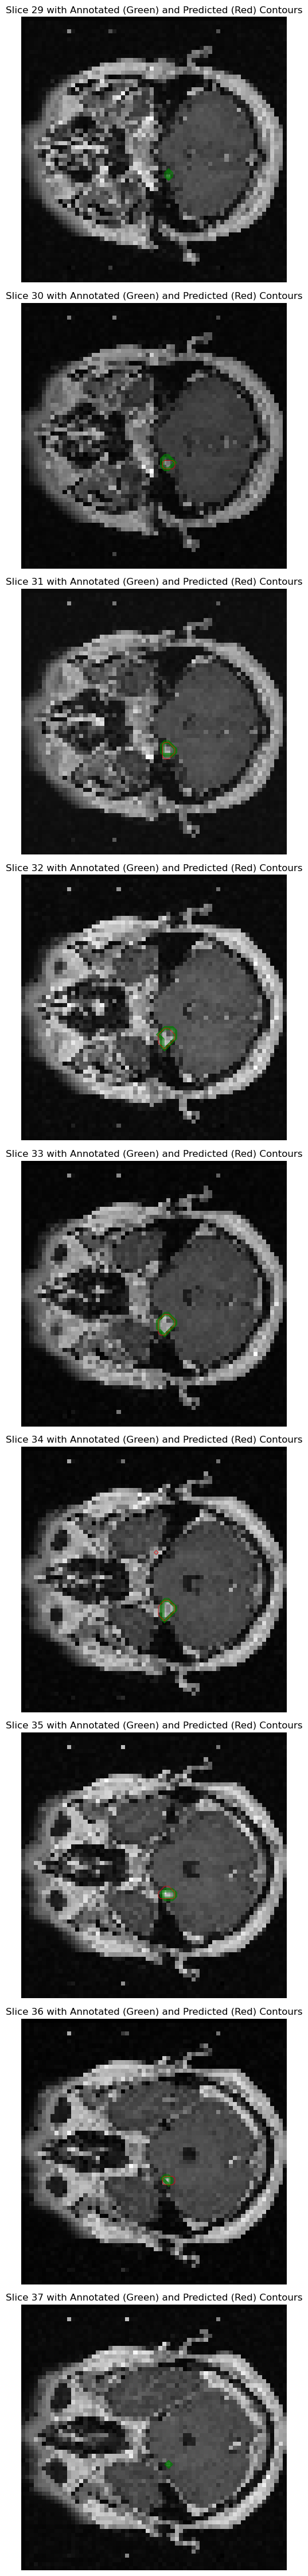

In [64]:
plot_test_image_with_contours(1, X_test, Y_test)


In [65]:
with pd.ExcelWriter(
    r"C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\avg_model_df.xlsx"
) as writer:
    avg_model_df.to_excel(writer, sheet_name="Avg model scores")